# COLX 565 Lab Assignment 2: Polarity and Aspects

## Assignment Objectives

In this assignment you will
- Perform Exploratory analysis on a multi-tagged corpus for emotion and sentiment (Exercise 1)
- Create a CNN-based classifier to predict sentiment from text (Exercise 2)
- Create a multi-task learner that tries to jointly learn sentiment and emotion (Exercise 3)
- Add on to the classifier using speech-extracted features. (Exercise 4)
- Create an ensemble that combines the previously-trained models to predict sentiment and emotion. (Exercise 5 - Optional)

## Getting Started

Run the code below to access relevant modules (you can add to this as needed)

In [1]:
#provided code
import json
from nltk import word_tokenize
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import torch
import pandas as pd
import random
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import torch.optim as optim
from nltk import word_tokenize
from torchtext.data.utils import get_tokenizer
###from torchtext.data import Field, RawField, NestedField, TabularDataset,BucketIterator
from torch.utils.data import Dataset, DataLoader, Sampler
from torchtext.vocab import Vocab
from torchdata.datapipes.iter import IterableWrapper, FileOpener
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence

## Tidy Submission

rubric={mechanics:1}

To get the marks for tidy submission:

- Submit the assignment by filling in this jupyter notebook with your answers embedded
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions)
- The corpus will be provided to you - don't include it in your submission. Modify the path below.

### Exercise 1: Exploring the MELD Corpus
rubric={accuracy:3, viz:1, reasoning:1}

**MELD: A Multimodal Multi-Party Dataset for Emotion Recognition in Conversations (https://aclanthology.org/P19-1050) (Poria et al., *ACL 2019*)**

![MELD](https://affective-meld.github.io/emotion_shift.jpeg "MELD")


The MELD (Multimodal EmotionLines Dataset) is a corpus of short video snippets from the TV series "Friends".  Each line has been annotated with the speaker (one of about 250 different characters - although most of them only speak a few times), whether the sentiment in the line is positive, negative, or neutral, and the emotion carried in the line (one of 7 emotions: neutral, surprise, joy, anger, sadness, fear, or disgust).

I've extracted the audio from the video files (if you're interested in how to do so, let me know), and provided you with both the annotations (which will serve as our "y" variables), and the sound and text data, which will serve as our "x" data.  Don't worry about the audio data at this point - just concentrate on the text data included in the csvs.

We're first going to do some exploratory data analysis (EDA).  Load up the training data, and provide some information regarding interesting statistics.  You should calculate and graph:

* the number of times that each of the 6 main characters (Monica, Chandler, Ross, Rachel, Phoebe, and Joey) speak.
* what percentage of each of their speech is positive / neutral / negative
* what percentage of each of their speech is associated with each of the 7 emotions

To get full marks, you must also provide a short (one paragraph) written analysis of what you find.

### MELD dataset: https://github.com/declare-lab/MELD/tree/master/data/MELD

In [2]:
!wget https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv
!wget https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/dev_sent_emo.csv
!wget https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/test_sent_emo.csv

--2024-02-26 20:41:12--  https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1119290 (1,1M) [text/plain]
Saving to: ‘train_sent_emo.csv’

train_sent_emo.csv  100%[===================>]   1,07M  7,07MB/s    in 0,2s    

2024-02-26 20:41:12 (7,07 MB/s) - ‘train_sent_emo.csv’ saved [1119290/1119290]

--2024-02-26 20:41:12--  https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/dev_sent_emo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [3]:
#provided code
data_dir = "./"

In [4]:
import pandas

train_path = data_dir + "train_sent_emo.csv"
train_data = pandas.read_csv(train_path)

train_data

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


average sentence length (chars): 40.52838121934128
average sentence length (words): 8.03543898288117
number of utterances per f.r.i.e.n.d.s: [0.18167589694196967, 0.1756561521791476, 0.172766674692993, 0.15904165663375872, 0.15639296893811702, 0.15446665061401396]
f.r.i.e.n.d.s: ['Joey', 'Ross', 'Rachel', 'Phoebe', 'Monica', 'Chandler']


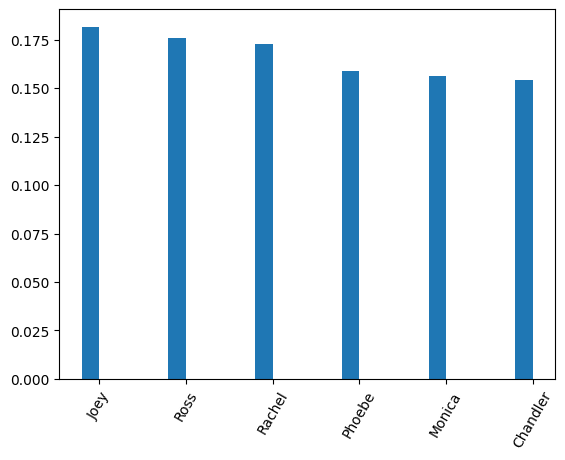

<Figure size 640x480 with 0 Axes>

positive, negative, neutral = red, blue, green


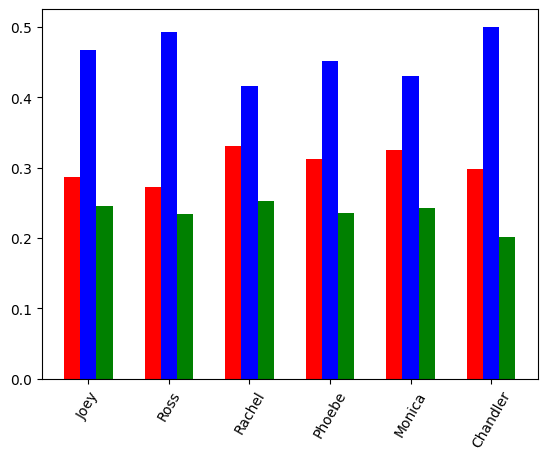

surprise, fear, sadness, neutral, joy, anger, disgust = purple, yellow, blue, black, orange, red, green


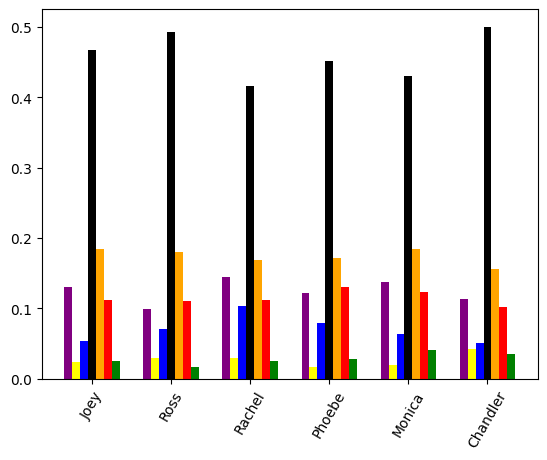

<Figure size 640x480 with 0 Axes>

In [4]:
# your code;



Analysis: 

-- Your answer;

### Exercise 2: Sentiment prediction using text

Now that you've gotten a feel for the data, it's time to build a classifier.

There are multiple ways to build a sentiment analyser, but we're going to be using a convolutional neural network (CNN).  We'll take a look at CNNs in class, but the "magic" of CNNs lies in something called a "convolutional" layer.  A convolutional layer passes a window over the entire data example, and learns to extract information; the window is then moved slightly, and the same information is extracted again, and again, and again.

For this task, we're going to be building a 1-dimensional convolutional layer of length 3.  This will move over words in the text, and then extract an embedding for those three words.  It will then shift one word, and extract an embedding from the next 3 words, etc.

Example:

I really like this movie.
```
                        |
                        V
"I really like"    -> [0.1,  0.5,  0.3] 
"really like this" -> [-0.2, -0.3, 0.4] 
"like this movie"  -> [-0.3, 0.1,  0.5] 
```

After extracting n-2 embeddings for the sequence, we will apply a max-pooling layer, which will grab the maximum value from each column (we could also do mean-pooling, or 2x2 pooling, or any other type of pooling, but we'll stick with max pooling).

Conv("I really like this movie") = [0.1, 0.5, 0.5]

You'll be provided with the CNN - you don't need to modify it in this exercise.

Also provided below is code that uses torchtext to build a representation of the MELD corpus, both input tokens and labels. You also don't need to know how this works (you are exploring torchtext in more detail in other courses of this program). Note that this code requires that you have set your data_dir correctly, and it actually creates some intermediate files in that directory, so the directory must be writable.





Images are from https://towardsdatascience.com/a-visualization-of-the-basic-elements-of-a-convolutional-neural-network-75fea30cd78d

![Conv](https://miro.medium.com/v2/resize:fit:1000/1*YvlCSNzDEBGEWkZWNffPvw.gif)


![Conv](https://miro.medium.com/v2/resize:fit:1000/1*WpOcRWlofm0Z0EDUTKefzg.gif)


------------------------------

![Max Pooling](https://miro.medium.com/v2/resize:fit:1000/1*LjXV6eQKTQcg-PJnBRE0VA.gif)



#### Exercise 2.0: Prepare the data

Pytorch requires that its data be in a very specific format - tensors of x values and y values that are then converted by the neural models into data we're interested in.   Data must first go through a pre-processing pipeline, including generating a vocabulary from the training data.  The following code converts the CSV provided into the appropriate data structure.  This code was modified from [here](https://github.com/andrei-radulescu-banu/stat453-deep-learning-ss21/blob/main/L15/packed_lstm.ipynb).

The torchtext pipeline first wraps the file in an iterator, then opens it and parses it.  We add a final filter that limits the data to just the first and 4th columns (ie, text and sentiment).  No modifications needed here, but you'll need them in later sections.

In [5]:
# provided code; 

### Code modified from https://github.com/andrei-radulescu-banu/stat453-deep-learning-ss21/blob/main/L15/packed_lstm.ipynb
VOCABULARY_SIZE = 20000
sentiments = {"neutral":"1", "positive":"0", "negative":"2"}
    
datapipe_train = IterableWrapper(["/Users/jungyeul/Downloads/565_Lab_2_2023/train_sent_emo.csv"])
datapipe_train = FileOpener(datapipe_train, mode='b')  ### Open the file
datapipe_train = datapipe_train.parse_csv(skip_lines=1) ### Parse, skipping the header
datapipe_train = datapipe_train.map(lambda row: [row[1], int(sentiments[row[4]])]) ###Limit data to 1th column (text) and 4th column (sentiment)

for sample in datapipe_train:
     print(sample)
     break

datapipe_dev = IterableWrapper(["/Users/jungyeul/Downloads/565_Lab_2_2023/dev_sent_emo.csv"])
datapipe_dev = FileOpener(datapipe_dev, mode='b')
datapipe_dev = datapipe_dev.parse_csv(skip_lines=1)
datapipe_dev = datapipe_dev.map(lambda row: [row[1], int(sentiments[row[4]])])

for sample in datapipe_dev:
    print(sample)
    break

['also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.', 1]
['Oh my God, he\x92s lost it. He\x92s totally lost it.', 2]


After loading the data, we need to create a vocabulary:

In [6]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

def get_vocab(train_datapipe):
    vocab = build_vocab_from_iterator(yield_tokens(train_datapipe), specials=["<SOS>", "<EOS>", "<UNK>", "<PAD>"], max_tokens=VOCABULARY_SIZE)
    vocab.set_default_index(vocab["<UNK>"])
    return vocab

In [9]:
vocab = get_vocab(datapipe_train)
print("Vocabulary size: ", len(vocab))
# PADDING_VALUE=vocab['<PAD>']
# vocab['<UNK>']

Vocabulary size:  6018


We're now going to define a short function that transforms a sequence of words into vocab:

In [10]:
def text_transform(input_seq, vocab):
    seq = [vocab[token] for token in tokenizer(input_seq)]
    seq = [vocab["<SOS>"]] + seq + [vocab["<EOS>"]] ### Add in start / end of sequence markers
    return seq

In [11]:
print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform("here is an example", vocab))

input to the text_transform: here is an example
output of the text_transform: [0, 53, 19, 128, 3781, 1]


The next bit of code will implement batching - finding sequences of similar length and grouping them together, with padding, if necessary.  It first requires a collation function, that indicates how instances should be collected together:

In [12]:
def collate_batch(batch):
    text_list, label_list = [], []
    for (_text, _label) in batch:
        processed_text = torch.tensor(text_transform(_text, vocab))
        text_list.append(processed_text)
        label_list.append(_label)
    return pad_sequence(text_list, padding_value=PADDING_VALUE).to(DEVICE), torch.tensor(label_list).to(DEVICE)

It then requires code that samples the data and finds items with similar length:

In [13]:
# Create our own sampler, to ensure we function with multiple worker threads
# See https://discuss.pytorch.org/t/using-distributedsampler-in-combination-with-batch-sampler-to-make-sure-batches-have-sentences-of-similar-length/119824/3
class BatchSamplerSimilarLength(Sampler):
    def __init__(self, dataset, batch_size, indices=None, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # get the indices and length
        self.indices = [(i, len(tokenizer(s[0]))) for i, s in enumerate(dataset)]
        # if indices are passed, then use only the ones passed (for ddp)
        if indices is not None:
            self.indices = torch.tensor(self.indices)[indices].tolist()

    def __iter__(self):
        # if self.shuffle:
        #     random.shuffle(self.indices)

        pooled_indices = []
        # create pool of indices with similar lengths
        for i in range(0, len(self.indices), self.batch_size * 100):
            pooled_indices.extend(sorted(self.indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
            self.pooled_indices = [x[0] for x in pooled_indices]
        
        # Comment in for validation
        #self.pooled_lengths = [x[1] for x in pooled_indices]
        #print(self.pooled_lengths)
        #print(self.pooled_indices)

        # yield indices for current batch
        batches = [self.pooled_indices[i:i + self.batch_size] for i in
                   range(0, len(self.pooled_indices), self.batch_size)]

        if self.shuffle:
            random.shuffle(batches)
        for batch in batches:
            yield batch

    def __len__(self):
        return len(self.pooled_indices) // self.batch_size

Now that we have our sampler, we can create our batches:

In [14]:
BATCH_SIZE = 64

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

datapipe_train_list = list(datapipe_train)
datapipe_dev_list = list(datapipe_dev)

train_loader = DataLoader(datapipe_train_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = datapipe_train_list, 
                                                                  batch_size=BATCH_SIZE), collate_fn=collate_batch)
dev_loader = DataLoader(datapipe_dev_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = datapipe_dev_list, 
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False), collate_fn=collate_batch)


In [15]:
#provided code
batch = next(iter(train_loader))
print("input shape:")
print(batch[0].shape)
print("input sample:")
print(batch[0][:, 0])
# print(batch[0][:])
print("label shape:")
print(batch[1].shape)
print("label sample:")
print(batch[1][0])
# print(batch[1].shape, batch[1])

input shape:
torch.Size([7, 64])
input sample:
tensor([  0, 131,   8,  23, 155,   4,   1])
label shape:
torch.Size([64])
label sample:
tensor(0)


Some information about the tensors: 

* The default batch size is 64 - this means we gather together 64 instances (of similar length) at a time for training and inference - that's why these tensors have 64 as the second dimension.  The CNN expects the batch dimension to be first - we'll be doing some manipulation of the dimensions inside the CNN.  
* The input is of size [14,64].  This means that we have 64 instances, each of length 14 (including padding).  The CNN requires that the batch dimension be first, but we'll fix that later.  It's much easier to read for us when we do it this way.
* Batches are created by sorting all of the training examples by length, so that all instances in a batch have the same length (in this case, 14).  If we couldn't find 64 instances of length 4, we take some shorter ones, and add the padding tokens.
* The output is just our ordinary labels that we had originally 

#### Exercise 2.1 - creating the CNN
rubric={accuracy:1}

We're going to be using a convolutional neural network (CNN) to train our sentiment classifier.  This is typical for sequential prediction tasks.  A CNN passes a sliding window over a sentence (we'll be working with a window of length 3).  It takes the embeddings of the words in that window, and performs a linear transformation on them.  We then end up n-k embedding for the entire sentence:

[0->2] <br>
[1->3] <br>
[2->4] <br>
[...] <br>
[n-2->n] <br>

Each vector is the same length, let's say m.

If we stack these separate vectors, then we get a matrix of size [n-k, m]:

[0 1 2 3 4 ...  m] <br>
[0 1 2 3 4 ...  m] <br>
[0 1 2 3 4 ...  m] <br>
[0 1 2 3 4 ...  m] <br>
[0 1 2 3 4 ...  m] <br>
[0 1 2 3 4 ...  m] <br>

For each column, we just take the maximum value, giving us a new vector length "m".

This is our "convolved" vector that will represent the sentence.  It's essentially a fuzzy n-gram detector.  We're also going to use dropout of 0.3.  I suggest you take a hard look at the provided code - you will be modifying it in the next exercise, so make sure you know exactly what the code is doing.

* This first bit of code represents the CNN - your job is to implement the forward function.

You will need to run the input sequence through:

        1. the embedding layer (`input_seq`)
        2. the dropout layer (`dropout_layer`)
        3. `permute` it so that the "sequence" dimension is last (where is it, currently?) 
                => we will put the sequence last. 1,2,3 -> 2,3,1;  to put the sequence last, as expected by the convolutional layers
                After dropout: (INPUT_SEQ, BATCH_SIZE, HIDDEN_DIM) -> (BATCH_SIZE, HIDDEN_DIM, INPUT_SEQ)
        4. run the result through the convolutional layer (`conv`)
        5. apply max pooling across the second dimension (for this, you can call `torch.max`)
            Hint: torch.max returns a tuple of indices and values - you want the values (see below)
        6. Call `F.relu` on the result, to activate it
        7. Apply the `dropout_layer` again
  

```
>>> a = torch.rand(3,3,3)
>>> a

                           axis = 1
                              |
        * axis = 0            V
tensor([[[*0.1292, 0.4502, 0.7906],  <---  axis = 2
         [0.5469, 0.6681, 0.5831],
         [0.9125, 0.6430, 0.7398]],

        [[*0.8346, 0.9417, 0.6099],
         [0.7979, 0.0380, 0.0628],
         [0.9640, 0.5319, 0.3050]],

        [[*0.0024, 0.7601, 0.4194],
         [0.0086, 0.1827, 1.0000],
         [0.0379, 0.2279, 0.8576]]])
>>> torch.max(a, axis=0)
torch.return_types.max(
values=tensor([[0.8346, 0.9417, 0.7906],
        [0.7979, 0.6681, 1.0000],
        [0.9640, 0.6430, 0.8576]]),
indices=tensor([[1, 1, 0],
        [1, 0, 2],
        [1, 0, 2]]))
>>> torch.max(a, axis=1)
torch.return_types.max(
values=tensor([[0.9125, 0.6681, 0.7906],
        [0.9640, 0.9417, 0.6099],
        [0.0379, 0.7601, 1.0000]]),
indices=tensor([[2, 1, 0],
        [2, 0, 0],
        [2, 0, 1]]))
>>> torch.max(a, axis=2)
torch.return_types.max(
values=tensor([[0.7906, 0.6681, 0.9125],
        [0.9417, 0.7979, 0.9640],
        [0.7601, 1.0000, 0.8576]]),
indices=tensor([[2, 1, 0],
        [1, 0, 0],
        [1, 2, 2]]))

# to get `values` of torch.max
>>> torch.max(a, axis=2).values
tensor([[0.7906, 0.6681, 0.9125],
        [0.9417, 0.7979, 0.9640],
        [0.7601, 1.0000, 0.8576]])
```

In [20]:
#provided code
class CNN(nn.Module):
    '''Converts a sentence into a fixed length vector representation using convolution and max pooling. Input to forward
    should be a matrix of token indices of shape (sequence length, batch size), output is a vector which represents the
    sentence, of shape (batch size, hidden_dim)'''
    def __init__(self, vocab_size, hidden_dim):
        super(CNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)        
        self.conv = nn.Conv1d(hidden_dim, hidden_dim, 3) # window size is 3
        self.dropout_layer = nn.Dropout(p=0.3) 
        
    def forward(self, input_seq):
        ### Your code here
        
        ### Your code here

#### Exercise 2.2
rubric={accuracy:1}

Now that you have a CNN that does max-pooling, you can add it as a layer  a regular FF NN.

The classifier should take the input, pass it through a CNN layer, and then a final Linear layer.  We'll be doing logistic regression, so you'll also want to pass it through a log softmax, so what we are returning are log probabilities.

    1. input go through `CNN`
    2. `linear`, 
    3. `F.log_softmax` (which `dim=?`)


In [21]:
#provided code
class CNNClassifier(nn.Module):
    '''Uses a CNN and a linear layer to provide (pre-Sigmoid) score for binary classification'''
    def __init__(self, vocab_size, hidden_dim):
        super(CNNClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.CNN = CNN(vocab_size, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 3)
        
    def forward(self, input_seq):
        ### Your code here
         


Now it's time to train and evaluate our classifier.  We'll run the model for 30 epochs (I recommend when debugging, set the value lower), and then evaluate.  You will know that your code from above was correct if the loss is decreasing with each epoch.  My loss was ~100 after 30 epochs (about 60 below where it started).  Training 30 epochs is pretty fast (our hidden layer is only 64 nodes, after all). It finishes training in less than a little more than a minute. 

In [22]:
#provided code

torch.backends.cudnn.deterministic = True  ### Try to ensure replicability
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)


epochs = 30 ### Train in a reasonable time, at the cost of overall accuracy
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# weights.to(device)

hidden_dim = 64 ### Keep models small.  Feel free to experiment with this value

# loss_function = nn.NLLLoss(weight=weights)  ### Since we are returning log_softmax, we are working with log-probabilities
loss_function = nn.NLLLoss()

vocab_size = len(vocab)
model = CNNClassifier(vocab_size, hidden_dim)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    epoch_loss = 0
    batch_counter = 0
    for data in train_loader:
        train_seq = data[0]
        train_labels = data[1]    
        model.zero_grad()
        train_seq, train_labels = train_seq.to(device), train_labels.to(device).float()
        score = model(train_seq)
        gold = torch.tensor([int(i.item()) for i in train_labels])
        loss = loss_function(score, gold)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print('After epoch:', epoch, 'Loss is:', epoch_loss)

After epoch: 0 Loss is: 159.8611958026886
After epoch: 1 Loss is: 144.7844859957695
After epoch: 2 Loss is: 140.0794302225113
After epoch: 3 Loss is: 137.9580042362213
After epoch: 4 Loss is: 135.0211929678917
After epoch: 5 Loss is: 133.32490891218185
After epoch: 6 Loss is: 131.42105853557587
After epoch: 7 Loss is: 128.17739355564117
After epoch: 8 Loss is: 127.10968834161758
After epoch: 9 Loss is: 124.95486617088318
After epoch: 10 Loss is: 124.2073672413826
After epoch: 11 Loss is: 121.68130320310593
After epoch: 12 Loss is: 120.92535150051117
After epoch: 13 Loss is: 119.351034283638
After epoch: 14 Loss is: 118.6497352719307
After epoch: 15 Loss is: 116.35184115171432
After epoch: 16 Loss is: 113.86126059293747
After epoch: 17 Loss is: 113.24722456932068
After epoch: 18 Loss is: 111.37214380502701
After epoch: 19 Loss is: 109.7791477739811
After epoch: 20 Loss is: 108.65479332208633
After epoch: 21 Loss is: 106.49020951986313
After epoch: 22 Loss is: 104.43540605902672
After ep

Now, it's time to evaluate your model.  We'll use the development data (which was already converted into an appropriate format).  Normally, we wouldn't evaluate on the development data - it's there to tune the model, and make sure we got it working (and to pick the best model).  After development, we evaluate on test - hopefully, the findings we got on our development data hold.

For your evaluation, you'll want to do several things.  First, set your model to "eval" mode (model.eval()).  Otherwise, the model will apply dropout during inference, which we definitely don't want!  Then, iterate through the development data, and compare the predictions made by your model to the gold labels.  I get about 81%, which is a tough baseline to beat - we've already beaten the "majority baseline" (ie, our model is learning, and not just picking the majority class).  Your numbers may be a little different because of some inherent randomness in pytorch.

In [26]:
#provided code
predictions = defaultdict(list)
golds = defaultdict(list)
model.eval() #needed because our model has dropout, otherwise it will be applied when predicting!
total = 0
correct = 0
counts = {}
pred_counts = {}
# confusion = {}
        
with torch.no_grad():
    for data in dev_loader:
        dev_seq = data[0]
        dev_labels = [x.item() for x in data[1]]
        
        dev_seq = dev_seq.to(device)
        scores = model(dev_seq)
        preds = [np.argmax(x) for x in scores.detach().cpu().numpy()]
        for i in preds:
            pred_counts[i] = pred_counts.get(i, 0) + 1
        for i in range(len(preds)):
            if preds[i] == dev_labels[i]:
                correct += 1
            counts[dev_labels[i]] = counts.get(dev_labels[i], 0) + 1
            counts["total"] = counts.get("total", 0) + 1     
            # confusion[str(dev_labels[i]) + ":" + str(preds[i])] = confusion.get(str(dev_labels[i]) + ":" + str(preds[i]), 0) + 1

        total += len(preds)
        
print("Accuracy: ", correct / total)  
# print(confusion)

Accuracy:  0.6321009918845807


#### Exercise 2.3
rubric={accuracy:1, reasoning:1}

Perform a high-level error analysis of the results.  You should modify the evaluation code above to create a confusion matrix of the results (ie, how many times did the model predict X, when the true value was Y?).  Do the results make sense, given what you know about sentiment?

Answer: 

#### Exercise 2.4 (Optional)
rubric={accuracy:1, reasoning:1}

We didn't do a check for the class distribution in the data, but from Exercise 1, we saw that it is not equal - there are far more neutral instances than anything else.  We can influence the model to work around this bias by providing class weights to the loss function.

We'll just do a simple calculation of the weights - find out how many of each class there are, and inversely weight the classes by the proportion.  The weights should be a tensor of floats that are then supplied to the [weight parameter in the loss function](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html).

Once you've generated the weights, you'll need to send them to your device, pass them to the loss function, and re-train / evaluate.  Write a short paragraph explaining any changes you see.

In [180]:
class_counter = Counter()

### Your code here


### Your code here
print(weights)
print(class_counter)


tensor([4.2798, 2.1208, 3.3919])
Counter({1: 4710, 2: 2945, 0: 2334})


Answer: 


### Exercise 3: Joint training

In exercise 2, we were just using the utterance to learn a classification model - a pretty standard X-> Y mapping.  But we have other information available that seems very closely-related: we know that emotion and sentiment are related to each other.  We could add in the emotion as an "X" value during training, but then, we would need to get it for every example during inference, which would defeat the purpose of training a model at all.  Instead, we're going to do something a bit different - we're going to use the emotion as another task to learn simultaneously with sentiment.

This task is typically called "Multi-Task learning" (MTL), or sometimes, "Joint learning".  The idea is that learning two related tasks will result in a stronger model than just learning one for each.

#### Exercise 3.1
rubric={accuracy:1}

The first thing we need to do is modify our data again - instead of just one class, we are now going to be predicting 2: sentiment and emotion.  You'll need to modify your Data loader so that on the label side, it produces a 1x2 tensor instead of a 1x1 one.

Feel free to copy the code from 2.0 here - you'll need to modify it to handle the new setting.
This will require modifications to the data pipeline and collate_batch function - everything else can stay the same, but you need to run the pipeline again.  The main thing is to transform the labels from a tensor of ints to a tensor of tuples of ints.

eg. [2, 1, 0] -> [(2,4), (1,3), (0,0)]


In [28]:
### Code modified from https://github.com/andrei-radulescu-banu/stat453-deep-learning-ss21/blob/main/L15/packed_lstm.ipynb

sentiments = {"neutral":"1", "positive":"0", "negative":"2"}
emotions = {"neutral":"0", "fear":"1", "anger":"2", "disgust":"3", "sadness":"4", "surprise":"5", "joy":"6"}

datapipe_train = IterableWrapper(["train_sent_emo.csv"])
datapipe_train = FileOpener(datapipe_train, mode='b')  ### Open the file
datapipe_train = datapipe_train.parse_csv(skip_lines=1) ### Parse, skipping the header
datapipe_train = datapipe_train.map(...)

for sample in datapipe_train:
     print(sample)
     break

datapipe_dev = IterableWrapper(["dev_sent_emo.csv"])
datapipe_dev = FileOpener(datapipe_dev, mode='b')
datapipe_dev = datapipe_dev.parse_csv(skip_lines=1)
datapipe_dev = datapipe_dev.map(...)

for sample in datapipe_dev:
    print(sample)
    break

# From Ex2:
# ['also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.', 1]
# ['Oh my God, he\x92s lost it. He\x92s totally lost it.', 2]

# For Ex3:
# ['also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.', 1, 0]
# ['Oh my God, he\x92s lost it. He\x92s totally lost it.', 2, 4]


['also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.', 1, 0]
['Oh my God, he\x92s lost it. He\x92s totally lost it.', 2, 4]


In [29]:
# # From Ex2:
# def collate_batch(batch):
#     text_list, label_list = [], []
#     for (_text, _label) in batch:
#         processed_text = torch.tensor(text_transform(_text, vocab))
#         text_list.append(processed_text)
#         label_list.append(_label)
#     return pad_sequence(text_list, padding_value=PADDING_VALUE).to(DEVICE), torch.tensor(label_list).to(DEVICE)

# For Ex 3:
# def collate_batch(batch):
#     text_list, label_list = [], []
#     for (_text, _label) in batch:                                                     <---  your batch should contains _sentiment and _emotion instead of _label
#         processed_text = torch.tensor(text_transform(_text, vocab))
#         text_list.append(processed_text)
#         label_list.append(_label)                                                     <--- append  _sentiment and _emotion;
#     return pad_sequence(text_list, padding_value=PADDING_VALUE).to(DEVICE), torch.tensor(label_list).to(DEVICE)


In [30]:
# same as in Ex2:
datapipe_train_list = list(datapipe_train)
datapipe_dev_list = list(datapipe_dev)

train_loader_joint = DataLoader(datapipe_train_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = datapipe_train_list, 
                                                                  batch_size=BATCH_SIZE), collate_fn=collate_batch)
dev_loader_joint = DataLoader(datapipe_dev_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = datapipe_dev_list, 
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False), collate_fn=collate_batch)

In [31]:
#provided code
batch = next(iter(train_loader_joint))
print("input shape:")
print(batch[0].shape)
print("input sample:")
print(batch[0][:, 0])
print("label shape:")
print(batch[1].shape)
print("label sample:")
print(batch[1][0])

input shape:
torch.Size([4, 64])
input sample:
tensor([  0, 187,   4,   1])
label shape:
torch.Size([64, 2])
label sample:
tensor([0, 6])


In [32]:
# previous results:
# -----------------------------
# input shape:
# torch.Size([17, 64])
# input sample:
# tensor([   0,   17,   75,   39,   44,    4,   38,  157,  831,  135,   50, 1731,
#         4959, 3350,    4,    1,    3])
# label shape:
# torch.Size([64])
# label sample:     
# tensor(1)             <---        previously one result, now TWO results! 

#### Exercise 3.2

Now that we have multiple output classes, we'll need to modify our CNN so it produces not one output distribution, but several.

You don't need to modify the CNN itself, but you'll need to modify the classifier.

Modify the CNNClassifier class (I highly recommend naming it something like "JointCNNClassifier") so that it takes a number of classifiers, so that it has 2 linear layers - one that transforms the embedded input into a sentiment distribution (as before), and one that transforms it into an emotion distribution (very similar).  The forward function should return both distributions.

In [ ]:
# From Ex2, class CNNClassifier(nn.Module):

# class JointCNNClassifier(nn.Module):
#     '''Uses a CNN and a linear layer to provide (pre-Sigmoid) score for binary classification'''
#     def __init__(self, vocab_size, hidden_dim):
#         super(CNNClassifier, self).__init__()                                 ---> super(JointCNNClassifier, self).__init__()
#         self.hidden_dim = hidden_dim                                          ---> idem
#         self.CNN = CNN(vocab_size, hidden_dim)                                ---> idem
#         self.linear1 = nn.Linear(hidden_dim, 3)                                ---> one for sentiment
#         self.linear2 = nn.Linear(hidden_dim, 7)                                ---> one for emotion
#         self.dropout_layer = nn.Dropout(p=0.3)                                ---> idem

#     def forward(self, input_seq):
#         ### Your code here
 
    # 1. input go through `CNN`
    # 2. `linear`, 
    # 3. `F.log_softmax` (which `dim=1`) --> one for semitment; another for emotiion; 
    # 4. return log_softmax values of sentiment and emotion;
 

#### Exercise 3.3
rubric={accuracy:1, quality:1}

Now, you need to modify the training algorithm to handle two different predictions.

This will require 2 loss functions: one for emotion, and one for sentiment (they can both be NLLLoss). There are many ways that we can combine these functions to modify the model, but we're just going to take the easiest way - add them together, and back-propagate through the model.

The steps you'll need to modify: 

1. Create a separate loss function for the sentiment and emotion
2. Separate out the gold sentiment labels and gold emotion labels
3. Separate predictions returned by the model
4. Calculate separate loss values for sentiment and emotion
5. Combine losses
6. Back-propagate (no modification is required - once the losses are added, calling loss.backward will do back-propagation.

You may also want to keep track of the epoch loss for sentiment and emotion separately.

In [ ]:
# From Ex2:



# torch.backends.cudnn.deterministic = True  ### Try to ensure replicability
# RANDOM_SEED = 42
# torch.manual_seed(RANDOM_SEED)

# epochs = 30 ### Train in a reasonable time, at the cost of overall accuracy
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# # weights.to(device)

# hidden_dim = 64 ### Keep models small.  Feel free to experiment with this value

# loss_function = nn.NLLLoss() 
    # -> You need to define two NLLoss()s for emotion and senti; 
    # -> emot_loss_function = nn.NLLLoss()
    # -> sent_loss_function = nn.NLLLoss()



# vocab_size = len(vocab)
# model = CNNClassifier(vocab_size, hidden_dim)                         ---> modelJoint = JointCNNClassifier(vocab_size, hidden_dim)
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(epochs):
#     epoch_loss = 0
    # ->     emot_epoch_loss = 0
    # ->     sent_epoch_loss = 0

#     batch_counter = 0
#     for data in train_loader:
#         train_seq = data[0]
#         train_labels = data[1]    
#         model.zero_grad()
#         train_seq, train_labels = train_seq.to(device), train_labels.to(device).float()
#         score = model(train_seq)
    # ->    scores = modelJoint(train_seq)
    # ->    sent_scores = 
    # ->    emot_scores = 

#         gold = torch.tensor([int(i.item()) for i in train_labels])
        # -> gold_sent = 
        # -> gold_emot = 

#         loss = loss_function(score, gold)
            # -> emot_loss = 
            # -> sent_loss = 
            # -> loss =                                                 ---> your loss is sum of sent_loss and emot_loss
#         loss.backward()

#         optimizer.step()
#         epoch_loss += loss.item()
            # -> emot_epoch_loss +=             
            # -> sent_epoch_loss += 
#     print('After epoch:', epoch, 'Loss is:', epoch_loss)
#     # break

After epoch: 0 Emotion Loss is: 236.7262768149376
After epoch: 0 Sentiment Loss is: 158.3451641201973
After epoch: 1 Emotion Loss is: 214.9758431315422
After epoch: 1 Sentiment Loss is: 144.53474378585815
After epoch: 2 Emotion Loss is: 209.38474696874619
After epoch: 2 Sentiment Loss is: 141.24635016918182
After epoch: 3 Emotion Loss is: 203.79699611663818
After epoch: 3 Sentiment Loss is: 138.09752088785172
After epoch: 4 Emotion Loss is: 200.99668502807617
After epoch: 4 Sentiment Loss is: 135.88494670391083
After epoch: 5 Emotion Loss is: 198.16450834274292
After epoch: 5 Sentiment Loss is: 133.626459389925
After epoch: 6 Emotion Loss is: 196.18797743320465
After epoch: 6 Sentiment Loss is: 132.77064526081085
After epoch: 7 Emotion Loss is: 193.36775296926498
After epoch: 7 Sentiment Loss is: 130.68901360034943
After epoch: 8 Emotion Loss is: 191.80103766918182
After epoch: 8 Sentiment Loss is: 129.2412519454956
After epoch: 9 Emotion Loss is: 188.57674032449722
After epoch: 9 Sent

#### Exercise 3.4 Evaluating joint training
rubric={accuracy:1, reasoning:1}

You will also need to modify your evaluation code to correctly evaluate your system.  Again, produce confusion matrices and briefly discuss what you see.

In [ ]:
# # From Ex2:

# #provided code
# predictions = defaultdict(list)
# golds = defaultdict(list)
# model.eval()                                        ---> modelJoint.eval() #needed because our model has dropout, otherwise it will be applied when predicting!
# total = 0
# correct = 0
#             ---> emot_correct = 0
#             ---> sent_correct = 0
# counts = {}
# pred_counts = {}
        
        
# with torch.no_grad():
#     for data in dev_loader:
#         dev_seq = data[0]
#         dev_labels = [x.item() for x in data[1]]
#             ---> sent_dev_labels = 
#             ---> emot_dev_labels = 
#         dev_seq = dev_seq.to(device)

#         scores = model(dev_seq)
#             ---> sent_scores = 
#             ---> emot_scores = 

#         preds = [np.argmax(x) for x in scores.detach().cpu().numpy()]
#             ---> emot_preds = [...  emot_scores.detach().cpu().numpy()]
#             ---> sent_preds = 

#         # go through emot_preds and sent_preds to get corret numbers; 
#         for i in range(len(preds)):
#             if preds[i] == dev_labels[i]:
#                 correct += 1

#         total += len(emot_preds)                  --> One total is enough; 
        
print("Emotion Accuracy: ", emot_correct / total) 
print("Sentiment Accuracy: ", sent_correct / total) 

Emotion Accuracy:  0.5500450856627592
Sentiment Accuracy:  0.6293958521190262


Answer: 

#### Exercise 3.5 (Optional):
rubric={accuracy:1, reasoning:1}

Perform some tuning on your model to try to improve your accuracy.  
Some suggestions - try adding in extra tasks that might have more information (do the characters get more positive / negative by season?)  Try re-weighting the classes like in Exercise 1.
Tune several parameters: hidden size and dropout size are good candidates, but you're free to tune whatever you feel like.  Make one of the tasks easier - what if we only predict positive / negative, instead of neutral?  What if we balance the classes (in any of our tasks?).  Report your findings.  Don't worry if you can't improve the quality that much (or at all).  An effort to investigate at least 2 of these ideas (or others you come up with) will get you your marks.

### Exercise 4: Sentiment from speech

As we all know, text is not the best mode for detecting sentiment / emotion.  Sarcasm, enthusiasm, boredom, and other emotions just don't come through in text like they do in speech.

You may have noticed, way back in Exercise 1, that MELD is a *multi-modal* data-set.  This means that along with textual data, it includes some other `mode` of data.  The original dataset contained video (another great mode for emotion!), but since we haven't worked with video, I won't be springing it on you here.

Instead, I've extracted the audio from the video files.  Remember that we've seen audio before, back in COLX 521.  We'll be extracting audio_features from some audio files using OpenSmile (I know that some of you cannot use OpenSmile - don't worry, I'll provide the features for you).

In [214]:
# For MacOS users, just "load" dev/train audio npz files; 


# !python3 -m pip install opensmile
# !python3 -m pip install --upgrade audresample
# !python3 -m pip install librosa

In [215]:

### Provided code - 
### this will load the audio features into dictionaries, and combine them into a single dictionary
full_data = {}
dev_audio = np.load(data_dir + "dev_audio.npz")
train_audio = np.load(data_dir + "train_audio.npz")
full_data.update(dev_audio)
full_data.update(train_audio)

#### Exercise 4.1
rubric{accuracy:1}

We're going to make a small change to the dataloader here - we'll include the dialogue number (column 5) and utterance number (column 6) - this will make things a lot easier when we get to training.



In [224]:
import pandas
train_path = data_dir + "train_sent_emo.csv"
train_data = pandas.read_csv(train_path)

train_data

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


In [225]:
# `datapipe_train.map` requires row[1], row[4] = sentiments, row[3] = emotions, row[5] and row[6];

In [226]:
### Your code here (reading CSV)
### Your code here (modified collate_batch)
### Your code to load the dataset here


['also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.', 1, 0, 0, 0]
['Oh my God, he\x92s lost it. He\x92s totally lost it.', 2, 4, 0, 0]


In [229]:
#provided code
batch = next(iter(train_loader_audio))
print("input shape:")
print(batch[0].shape)
print("input sample:")
print(batch[0][:, 0])
print("label shape:")
print(batch[1].shape)
print("label sample:")
print(batch[1][0])
print("audio sample:")
print(batch[2][0])

input shape:
torch.Size([23, 64])
input sample:
tensor([   0,   47,   50, 2136,   53,    4,   70,    5,    8,   10,  148,  203,
          13,  553, 2571,   29, 1135,   31,  354,  617,    4,    1,    3])
label shape:
torch.Size([64, 2])
label sample:
tensor([1, 0])
audio sample:
tensor([459,   9])


#### Exercise 4.2
rubric{accuracy:2, quality: 1}

We're going to modify the CNN class to accept audio low-level features (25 of them) as an "embedding" of the audio signal.  This will be similar to how we are processing text, except that we won't be running the data through an embedding layer.

We'll need a second convolutional layer in the model, that converts from the size 25 embedding to the hidden dimension.  You'll need to permute the audio file so that it fits the convolutional layer (hint: the sequence size should be last.).  After running the text and audio through their separate convolutional layers and applying activation and dropout, you should return both values.  They'll be dealt with by the classifier module.

In [230]:
#provided code
class AudioCNN(nn.Module):
    '''Converts a sentence into a fixed length vector representation using convolution and max pooling. Input to forward
    should be a matrix of token indices of shape (sequence length, batch size), output is a vector which represents the
    sentence, of shape (batch size, hidden_dim)'''
    def __init__(self, vocab_size, hidden_dim):   
        ...

    def forward(self, input_seq, audio):
        ...
        return (return_val_text, return_val_audio)

#### Exercise 4.3
rubric={accuracy:1, quality:1}

Now that we've passed everything through the CNN, we need to modify the audio classifier to work on this new data.

We're just going to be concatenating the text and audio output from the convolutional layer.  This data is {batch x hidden}, so when we concatenate it, we'll have {batch x hidden * 2}, which will be passed to the final linear layers, as before (this means you'll have to modify the size of those layers in the init function...)

You can return the prediction distributions for emotion and sentiment, as before.

In [231]:
#provided code
class AudioCNNClassifier(nn.Module):
    '''Uses a CNN and a linear layer to provide (pre-Sigmoid) score for binary classification'''
    def __init__(self, vocab_size, hidden_dim):
        ...

    def forward(self, input_seq,audio):
        ...
        
        return sent, emot

#### Exercise 4.4
rubric{accuracy:1, quality:1}

Now, we again need to modify the training algorithm.  There are two main things that we need to do - some of the data is corrupted, so it needs to be replaced.  You'll need to loop through the batch, and if any of the dialogue / utterance pairs are not in full_data, then you need to add an empty matrix (100x25 zeros is fine).  You'll then need to grab the matrix from full_audio for each item in the batch.

Secondly, you'll need to pad the audio data (batches are matched on text, not audio).  You can use the provided function:

You'll provide the padded audio to the model.

In [232]:
def pad_seq(to_pad):
    ''' Takes a batch of data, and pads any shorter sequences so that all items are the same length'''
    max_cols = max([len(row) for instance in to_pad for row in instance])  ### Maximum number of columns in the batch
    max_rows = max([len(instance) for instance in to_pad]) ### Maximum number of rows in the batch
    padded = []
    for i in to_pad:
        instance = [[0] * (max_cols)] * (max_rows - len(i))  ### Create a bunch of zeros to add to the end of the sequence
        if(max_rows != len(i)):
            instance = np.concatenate([i, instance]) ### Add the rows to the end of the sequence
        else:
            instance = i
        padded.append(instance)
    padded = torch.tensor(np.array(padded))
    return padded


In [233]:
### Your modified training code here


After epoch: 0 Emotion Loss is: 232.16262447834015
After epoch: 0 Sentiment Loss is: 153.03723645210266
After epoch: 1 Emotion Loss is: 212.78395926952362
After epoch: 1 Sentiment Loss is: 143.70107811689377
After epoch: 2 Emotion Loss is: 206.28683656454086
After epoch: 2 Sentiment Loss is: 139.5942583680153
After epoch: 3 Emotion Loss is: 202.87514758110046
After epoch: 3 Sentiment Loss is: 137.01324808597565
After epoch: 4 Emotion Loss is: 199.15678256750107
After epoch: 4 Sentiment Loss is: 134.38190406560898
After epoch: 5 Emotion Loss is: 197.2995782494545
After epoch: 5 Sentiment Loss is: 132.84787422418594
After epoch: 6 Emotion Loss is: 193.43419164419174
After epoch: 6 Sentiment Loss is: 130.61021852493286
After epoch: 7 Emotion Loss is: 191.27298551797867
After epoch: 7 Sentiment Loss is: 128.77414482831955
After epoch: 8 Emotion Loss is: 189.12424558401108
After epoch: 8 Sentiment Loss is: 127.03430980443954
After epoch: 9 Emotion Loss is: 188.4457894563675
After epoch: 9 S

### Exercise 4.5
rubric={reasoning:1}

Finally, we need to do the same thing with the evaluation code.  

In [36]:
### Your modified evaluation code.


ANSWER: 




#### Exercise 5: Ensembling (Optional)
rubric:{accuracy: 1, reasoning: 1}

Another way of combining multiple pieces of data is to train separate models, and then combine their predictions in some way - this is known as "ensembling".  Each model makes predictions, and then they are combined in some way - one common way is to use the probabilities of the models as a "confidence" score for the selections, and then to just add them up.  In this exercise, you'll be modifying the evaluation code to create an ensemble.  You are free to combine the score any way you feel works, but make sure to provide your motivation in the reasoning part of this answer.  

ANSWER:

### Exercise 5: Ensembling (Optional)¶


Good job!